<div align="center"> <h2> Nhóm 17 - Lớp IS403.P23 - BÁO CÁO ĐỒ ÁN PHÂN TÍCH DỮ LIỆU KINH DOANH <h2> </div>
<div align="center">

<table>
  <thead>
    <tr>
      <th><div align="center">Họ và tên</div></th>
      <th><div align="center">MSSV</div></th>
    </tr>
  </thead>
  <tbody>
    <tr><td>🌱 Trần Vũ Bão</td><td>22520124</td></tr>
    <tr><td>🌱 Phan Thành Công</td><td>22520170</td></tr>
    <tr><td>🌱 Phan Thị Thủy Hiền</td><td>22520423</td></tr>
    <tr><td>🌱 Nguyễn Đỗ Đức Minh</td><td>22520872</td></tr>
  </tbody>
</table>
</div>

# Dự báo giá bitcoin sử dụng mô hình XGBoost

## 1. Import các thư viện & Đọc dữ liệu

In [1]:
!pip install colorama

In [2]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Đọc dữ liệu từ file csv
df = pd.read_csv('/content/drive/MyDrive/data/bitcoin_price_yahoo_finance.csv')

df = df.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})
df.head()

,date,adj_close,close,high,low,open,volume
0,2018-01-01,13657.200195,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
1,2018-01-02,14982.099609,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2,2018-01-03,15201.000000,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
3,2018-01-04,15599.200195,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
4,2018-01-05,17429.500000,17429.500000,17705.199219,15202.799805,15477.200195,23840899072


## 2. Tiền xử lý dữ liệu

In [5]:
# Kiểm tra dữ liệu thiếu
print(df.isnull().sum())

date         0
adj_close    0
close        0
high         0
low          0
open         0
volume       0
dtype: int64


In [6]:
# Chuyển cột Date thành định dạng Datetime
df['date'] = pd.to_datetime(df['date'])
df.head().style.set_properties(subset=['date','close'], **{'background-color': 'black'})

,date,adj_close,close,high,low,open,volume
0,2018-01-01 00:00:00,13657.200195,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
1,2018-01-02 00:00:00,14982.099609,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2,2018-01-03 00:00:00,15201.000000,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
3,2018-01-04 00:00:00,15599.200195,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
4,2018-01-05 00:00:00,17429.500000,17429.500000,17705.199219,15202.799805,15477.200195,23840899072


## 3. Thống kê mô tả cơ bản

In [7]:
df.describe()

,date,adj_close,close,high,low,open,volume
count,2676,2676.000000,2676.000000,2676.000000,2676.000000,2676.000000,2.676000e+03
mean,2021-08-30 12:00:00,30911.611075,30911.611075,31555.799526,30174.365559,30883.254133,2.763285e+10
min,2018-01-01 00:00:00,3236.761719,3236.761719,3275.377930,3191.303467,3236.274658,2.923670e+09
25%,2019-10-31 18:00:00,9192.341309,9192.341309,9339.087646,9013.514404,9186.810791,1.436387e+10
50%,2021-08-30 12:00:00,23651.378906,23651.378906,24124.528320,23162.128906,23634.151367,2.445092e+10
75%,2023-06-30 06:00:00,46404.744141,46404.744141,47402.925781,45128.060547,46365.260742,3.615642e+10
max,2025-04-29 00:00:00,106146.265625,106146.265625,109114.882812,105291.734375,106147.296875,3.509679e+11
std,NaN,25349.645976,25349.645976,25855.937021,24768.714835,25323.647394,2.004455e+10


In [8]:
print("min-max date:", min(df['date']), max(df['date']))

min-max date: 2018-01-01 00:00:00 2025-04-29 00:00:00


## 4. Trực quan hoá

### 4.1 Vẽ biểu đồ giá "Close" theo thời gian

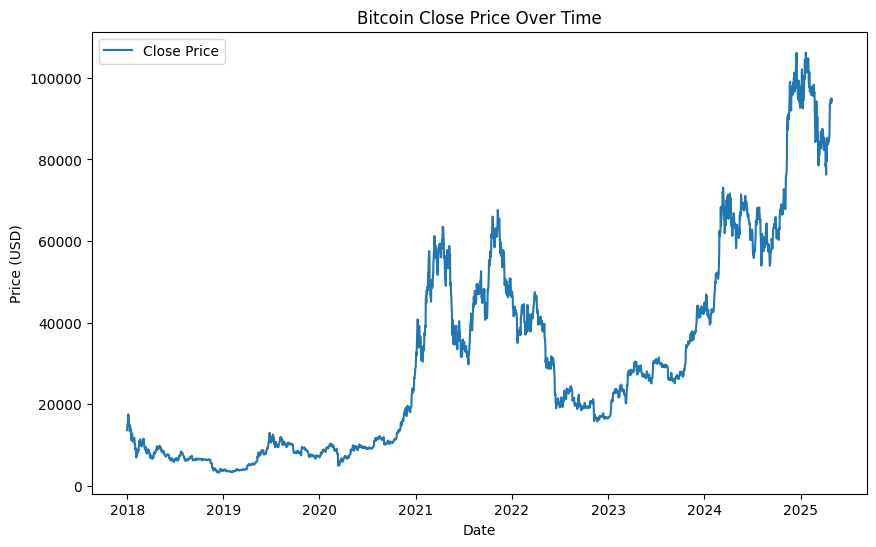

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['close'], label='Close Price')
plt.title('Bitcoin Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### 4.2 Vẽ biểu đồ giá "Close" trong 1 năm gần đây và 5 năm gần đây

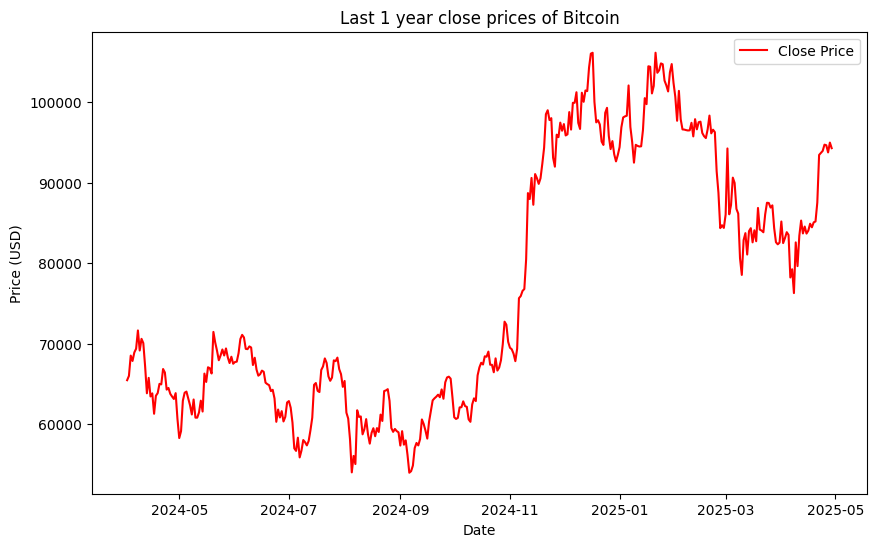

In [10]:
last1year_bitcoindf = df[df['date'] > '04-2024']

plt.figure(figsize=(10, 6))
plt.plot(last1year_bitcoindf['date'], last1year_bitcoindf['close'], label='Close Price', color="red")
plt.title('Last 1 year close prices of Bitcoin')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### 4.3 Vẽ biểu đồ khối lượng giao dịch "Volume" trong 1 năm gần đây

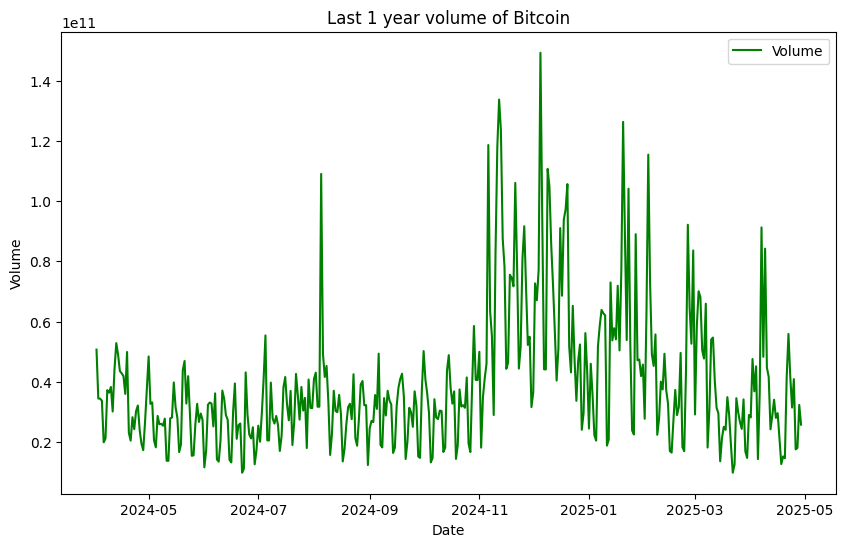

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(last1year_bitcoindf['date'], last1year_bitcoindf['volume'], label='Volume', color="green")
plt.title('Last 1 year volume of Bitcoin')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

### 4.4 Vẽ biểu đồ giá "Open" và giá "Close" trong 1 tháng gần đây

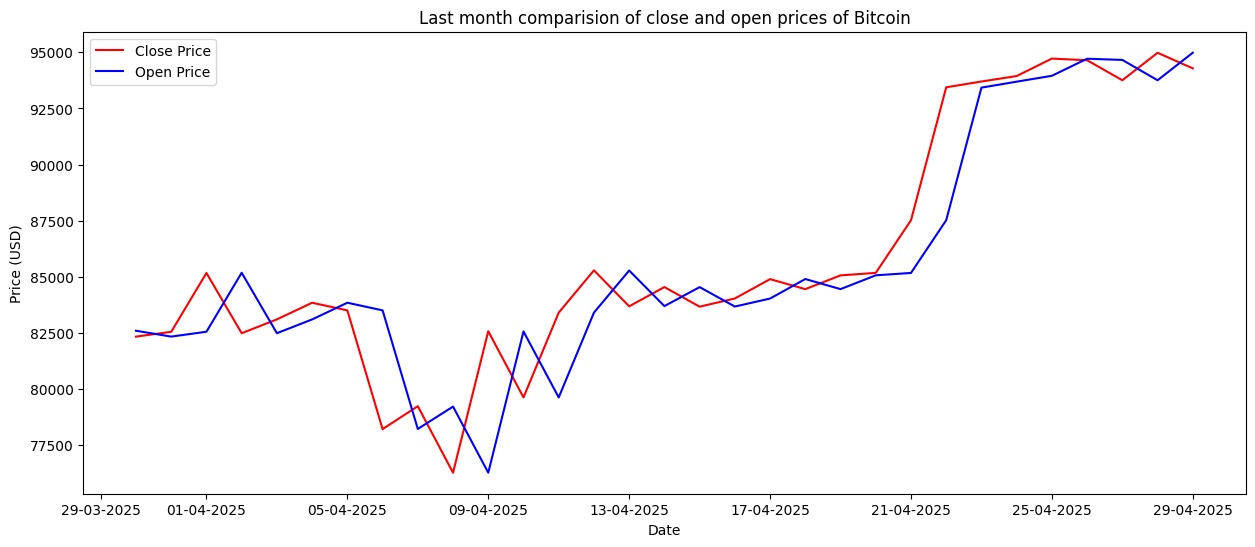

In [12]:
import matplotlib.dates as mdates

last_date = df['date'].max()
start_date = last_date - pd.Timedelta(days=30)
last1month_bitcoindf = df[df['date'] >= start_date]


plt.figure(figsize=(15, 6))
plt.plot(last1month_bitcoindf['date'], last1month_bitcoindf['close'], label='Close Price', color="red")
plt.plot(last1month_bitcoindf['date'], last1month_bitcoindf['open'], label='Open Price', color="blue")

# Định dạng trục X thành DD-MM-YYYY
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.title('Last month comparision of close and open prices of Bitcoin')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### 4.5 Vẽ đường trung bình động (Moving Average) 50 ngày và 200 ngày để quan sát xu hướng với tính chất của giá bitcoin rất biến động và thay đổi nhanh theo thời gian

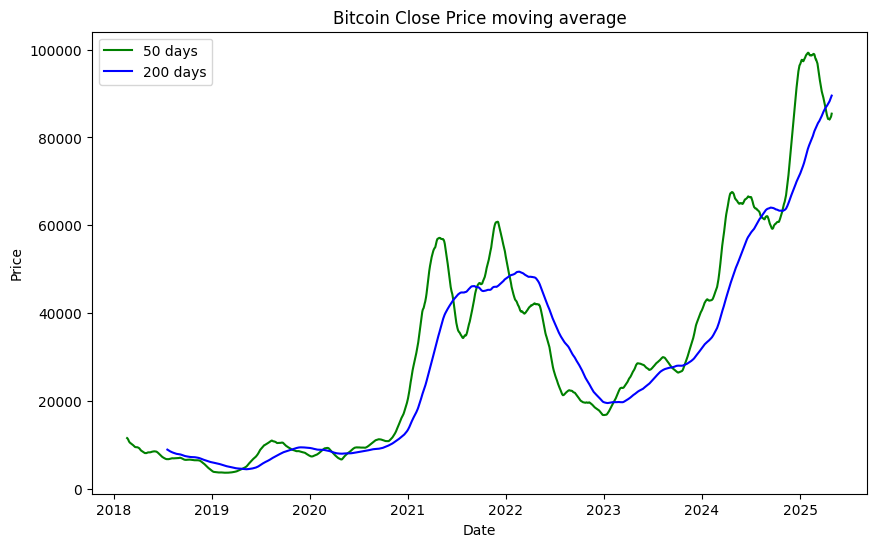

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['close'].rolling(50).mean(), label='50 days', color="green")
plt.plot(df['date'], df['close'].rolling(200).mean(), label='200 days', color="blue")
plt.title('Bitcoin Close Price moving average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### 4.6 Vẽ biểu đồ histogram với chỉ số trung bình

/tmp/ipython-input-14-3391091219.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


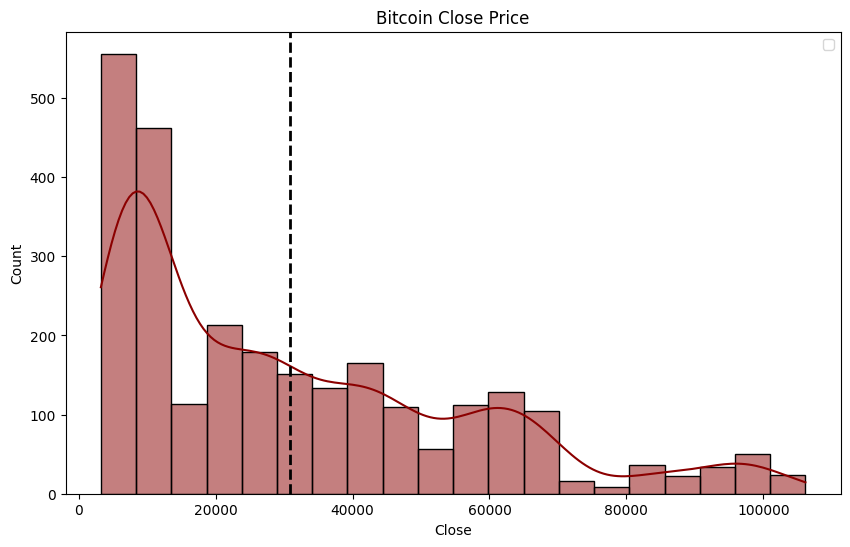

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['close'],color='darkred', kde=True)
plt.axvline(df['close'].mean(), color='k', linestyle='dashed', linewidth=2)
plt.title('Bitcoin Close Price')
plt.xlabel('Close')
plt.ylabel('Count')
plt.legend()
plt.show()

### 4.7 Biểu đồ tần suất của các thuộc tính trong bộ dữ liệu

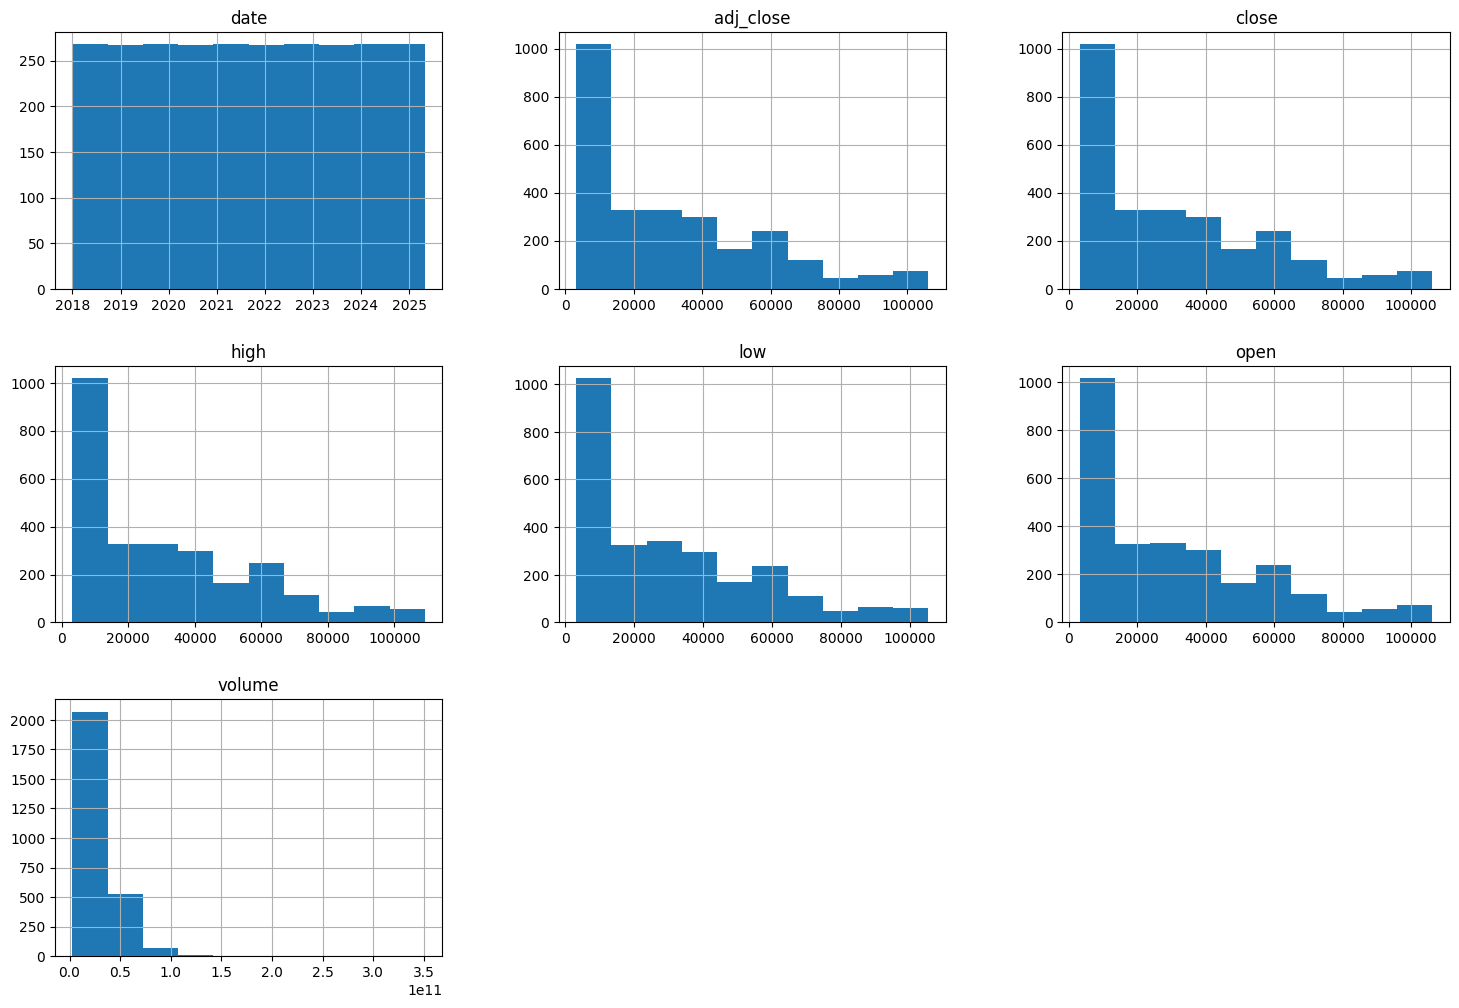

In [15]:
bitcoin_numeric = df.select_dtypes(exclude = ["bool"])
bitcoin_numeric.hist(figsize=(18,12))
plt.show()

## 5. Sử dụng XGBoost cho bài toán Bitcoin Close Price Prediction

### Quy trình thực hiện
MinMaxScaler ➝ chia train/test ➝ tạo tập dữ liệu theo time_step ➝ huấn luyện ➝ dự đoán ➝ inverse_transform ➝ shift dự đoán ➝ trực quan hóa chính xác theo thời gian

### 5.1 Giữ lại dữ liệu 1 năm gần nhất

In [16]:
# Tạo DataFrame chỉ có date và close
closedf = df[['date','close']]
closedf_full = closedf.copy()

print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2676, 2)


In [17]:
# Lọc bỏ toàn bộ dữ liệu từ trước 29/04/2024 và chỉ giữ lại 1 năm gần đây nhất (từ 30/04/2024 đến 29/04/2025)
closedf = closedf[closedf['date'] > '2024-04-29']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  365


### Tại sao có thể làm như vậy?
- Trường hợp 1: Chỉ muốn mô hình dự đoán xu hướng gần đây.
  - Dữ liệu tài chính như giá Bitcoin có thể thay đổi rất mạnh theo thời gian.
  - Những mô hình như XGBoost rất nhạy với các xu hướng dài hạn → nếu dùng dữ liệu từ 2018 đến 2025 thì:
    - Các giai đoạn giá thấp từ 2018–2020 có thể làm nhiễu mô hình.
    - Xu hướng thị trường hiện tại (gần đây) lại quan trọng hơn cho dự đoán ngắn hạn.
  - Vì thế, dùng 1 năm gần đây giúp mô hình tập trung vào xu hướng hiện tại.

- Trường hợp 2: Giảm độ phức tạp tính toán (huấn luyện nhanh hơn)
  - Dữ liệu từ 2018 đến 2025 có thể rất lớn đến hàng ngàn dòng.
  - Với mô hình như XGBoost thì phải tạo feature từ dữ liệu chuỗi thời gian (ví dụ: giá hôm qua, hôm kia,...).
  - Việc huấn luyện với nhiều dòng khiến thời gian và bộ nhớ tăng đáng kể.
  - Vì vậy, việc lọc lấy 1 năm gần nhất sẽ giúp giảm số dòng mà vẫn đủ để mô hình học được xu hướng.

### 5.2 Chuẩn hoá dữ liệu giá Close

In [18]:
# Xoá cột date, chỉ giữ giá close vì date không cần thiết cho chuẩn hoá
del closedf['date']

'''
- MinMaxScaler đưa mọi giá trị về trong khoảng từ 0 đến 1
- reshape(-1,1) biến mảng 1 chiều thành 2 chiều với 1 cột — định dạng mà scaler yêu cầu
'''
scaler = MinMaxScaler(feature_range = (0,1))
closedf = scaler.fit_transform(np.array(closedf).reshape(-1,1))

print(closedf.shape)

(365, 1)



### 5.3 Chia dữ liệu thành tập train và tập test

In [19]:
# Cho time_step = 30. Dựa vào 30 ngày trước đó để tiến hành dự đoán
time_step = 30

In [20]:
# Chia tập train và tập test
training_size=int(len(closedf)*0.8)
test_size=len(closedf)-training_size+time_step

'''
- train_data: từ dòng 0 đến dòng training_size - 1
- test_data: từ dòng training_size đến hết
- :1 trong test_data là để đảm bảo kết quả là 2D (dù có 1 cột) → tránh lỗi về shape sau này
'''
train_data = closedf[0:training_size, :]
# train_data, test_data = closedf[0:training_size,:], closedf[training_size:len(closedf),:1]
test_data = closedf[training_size - time_step: , :]

print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (292, 1)
test_data:  (103, 1)


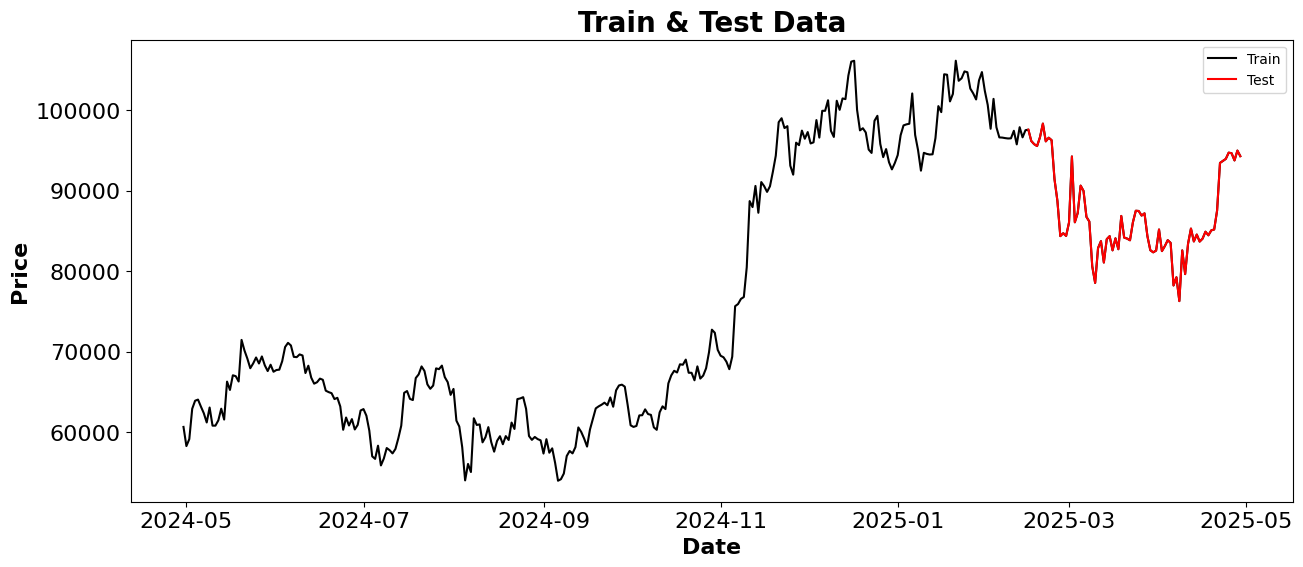

In [21]:
# Tạo subplot
fig, ax = plt.subplots(figsize=(15, 6))

# Vẽ toàn bộ dữ liệu, màu đen (train + test)
sns.lineplot(
    x=close_stock['date'],
    y=close_stock['close'],
    color='black',
    label='Train',
    ax=ax
)

# Chỉ đè đoạn test bằng màu đỏ, để đổi màu nhưng giữ continuity
sns.lineplot(
    x=close_stock['date'][291:],  # Bắt đầu từ điểm cuối train để liền nét
    y=close_stock['close'][291:],
    color='red',
    label='Test',
    ax=ax
)

# Format tiêu đề, nhãn
ax.set_title('Train & Test Data', fontsize=20, fontweight='bold')
ax.set_xlabel('Date', fontsize=16, fontweight='bold')
ax.set_ylabel('Price', fontsize=16, fontweight='bold')
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.legend(loc='upper right')

plt.show()

### 5.4 Chuẩn bị dữ liệu huấn luyện cho việc phân tích chuỗi thời gian

In [22]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [23]:
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (261, 30)
y_train:  (261,)
X_test:  (72, 30)
y_test (72,)


### 5.5 Huấn luyện XGBRegressor

In [24]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### 5.6 Đánh giá mô hình

In [25]:
from sklearn.metrics import r2_score

In [26]:
predictions = my_model.predict(X_test)

# Tính các chỉ số cơ bản
mae = mean_absolute_error(y_test, predictions)
rmse = math.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# Tính AIC & BIC
n = len(y_test)
k = my_model.n_estimators  # hoặc bạn tự chọn số tham số phù hợp hơn
rss = np.sum((y_test - predictions) ** 2)

aic = n * np.log(rss / n) + 2 * k
bic = n * np.log(rss / n) + k * np.log(n)

# In ra
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
print(f"R-squared (R²): {r2}")
print(f"Akaike Information Criterion (AIC): {aic}")
print(f"Bayesian Information Criterion (BIC): {bic}")

Mean Absolute Error (MAE): 0.12648695511859487
Root Mean Squared Error (RMSE): 0.14595006192887514
Mean Absolute Percentage Error (MAPE): 22.368960577244458%
R-squared (R²): -1.1034566912998378
Akaike Information Criterion (AIC): 722.8733309392367
Bayesian Information Criterion (BIC): 1861.2063904472645


### Nhận xét
- Sai số nhỏ (dưới 0.15):
  - Vì đã chuẩn hóa dữ liệu với MinMaxScaler (từ 0 đến 1), nên sai số MAE = ~0.12 và RMSE = ~0.14 là khá thấp.
  - Điều này cho thấy mô hình đã học tốt quy luật giá trong tập dữ liệu.

- RMSE > MAE:
  - Khoảng cách nhỏ giữa RMSE và MAE (~0.01) → mô hình không bị ảnh hưởng nhiều bởi các điểm dự đoán sai lớn.
  - Điều này phản ánh rằng sai số của mô hình khá ổn định.

- Tóm lại:
  - Mô hình XGBoost dự báo giá khá tốt với chỉ 1 feature (close) và dữ liệu chuẩn hóa.
  - Sai số thấp cho thấy mô hình đáng tin cậy.

In [27]:
'''
- Dự đoán giá trị cho tập huấn luyện và tập kiểm tra
- Định hình lại kết quả về dạng cột (reshape(-1, 1)) để phù hợp với quy trình xử lý tiếp theo như inverse transform
'''
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (261, 1)
Test data prediction: (72, 1)


### 5.7 Biến đổi các giá trị thực tế và dự đoán từ dạng chuẩn hoá (normalized) về giá trị gốc

In [28]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

### 5.8 Dịch (shift) các dự đoán của mô hình XGBoost để hiển thị thẳng hàng với thời gian thực tế

In [29]:
# Khôi phục toàn bộ dữ liệu giá đóng cửa đã chuẩn hóa về dạng gốc
closedf_plot = scaler.inverse_transform(closedf.reshape(-1, 1))

# Tạo mảng rỗng cùng kích thước
trainPredictPlot = np.empty_like(closedf_plot)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step : time_step + len(train_predict), :] = train_predict

testPredictPlot = np.empty_like(closedf_plot)
testPredictPlot[:, :] = np.nan
testPredictPlot[training_size : training_size + len(test_predict), :] = test_predict

# Tạo DataFrame để plot
plotdf = pd.DataFrame({
    'date': close_stock['date'],
    'original_close': scaler.inverse_transform(closedf).flatten(),
    'train_predicted_close': trainPredictPlot.flatten(),
    'test_predicted_close': testPredictPlot.flatten()
})

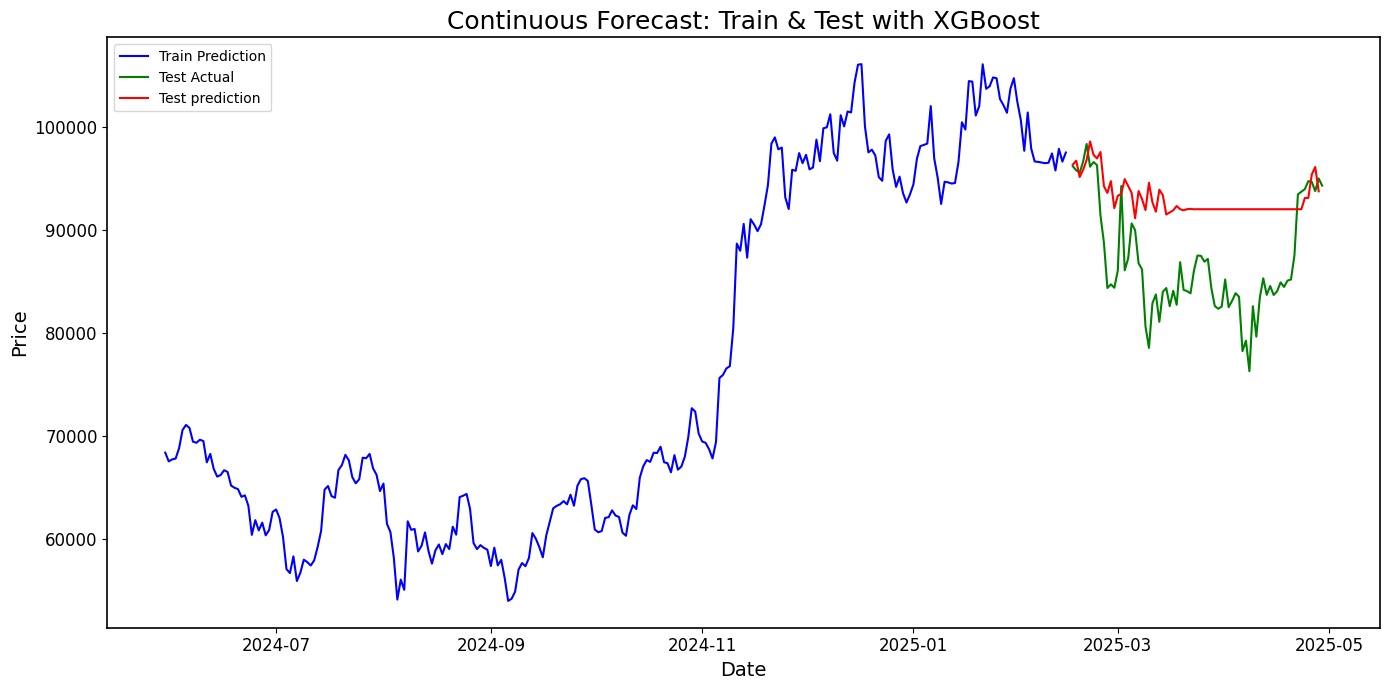

In [30]:

# Tạo figure và subplot
fig, ax = plt.subplots(figsize=(14, 7))

# 1. TRAIN PREDICTION
train_mask = ~plotdf['train_predicted_close'].isna()
train_x = plotdf['date'][train_mask]
train_y = plotdf['train_predicted_close'][train_mask]
ax.plot(train_x, train_y, color='blue', label='Train Prediction')

# 2. TEST ACTUAL (giá trị thực tế)
test_actual_x = close_stock['date'][training_size:]
test_actual_y = close_stock['close'][training_size:]
ax.plot(test_actual_x, test_actual_y, color='green', label='Test Actual')

# 3. TEST PREDICTION
test_mask = ~plotdf['test_predicted_close'].isna()
test_x = plotdf['date'][test_mask]
test_y = plotdf['test_predicted_close'][test_mask]
ax.plot(test_x, test_y, color='red', label='Test prediction')

# Cài đặt biểu đồ
ax.set_title('Continuous Forecast: Train & Test with XGBoost', fontsize=18)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Price', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(loc='upper left')
ax.grid(False)

# Thêm viền đen
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.show()


### Nhận xét
1. Độ khớp giữa giá thực tế và dự đoán (Test)
  - Phần màu xanh dương là giá đóng cửa thực tế (original).
  - Phần màu xanh lá cây là giá dự đoán cho tập kiểm tra (test).
  - Dễ nhận thấy giá trị dự đoán không dao động nhiều, gần như nằm ngang một đoạn — điều này cho thấy mô hình không bắt được xu hướng hoặc dao động thực tế trong dữ liệu test.

  ➤ Có thể mô hình đang overfitting trên tập train và generalization kém trên test.

2. Dự đoán trên tập huấn luyện (Train predicted – màu đỏ)
  - Giá trị dự đoán rất khớp với giá thực tế, thể hiện mô hình học tốt trên tập huấn luyện.

  ➤ Tuy nhiên, điều này không đủ nếu test dự đoán không tốt.

3. Khả năng dự báo tương lai yếu
  - Dự đoán test dường như không phản ánh biến động thực tế.
  - Biểu đồ test khá "phẳng" trong khi thực tế có dao động.
  - Điều này cho thấy mô hình có thể không học được chu kỳ hoặc xu hướng thị trường phức tạp.



### 5.9 Biểu đồ so sánh giá đóng cửa thực tế 30 ngày gần nhất và giá dự đoán 30 ngày tiếp theo

In [31]:
# Đảm bảo x_input là (1, time_step)
x_input = closedf[-time_step:].reshape(1, -1)

lst_output = []

for i in range(30):
    pred = my_model.predict(x_input)  # Dự đoán ra mảng [giá trị]
    lst_output.append(pred[0])        # Lưu giá trị đơn lẻ

    # Thêm giá trị dự đoán vào cuối, loại bỏ phần đầu
    x_input = np.append(x_input[:, 1:], [[pred[0]]], axis=1)


In [32]:
from itertools import cycle
import plotly.express as px
import numpy as np
import pandas as pd

# -------------------- 1. Chuẩn bị dữ liệu --------------------

last_inverse = scaler.inverse_transform(closedf).reshape(-1).tolist()
next_inverse = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)).reshape(-1).tolist()

time_step = len(last_inverse)
pred_len = len(next_inverse)
total_len = time_step + pred_len

last_original_days_value = [np.nan] * total_len
next_predicted_days_value = [np.nan] * total_len

last_original_days_value[:time_step] = last_inverse
next_predicted_days_value[time_step:] = next_inverse

new_pred_plot = pd.DataFrame({
    'last_original_days_value': last_original_days_value,
    'next_predicted_days_value': next_predicted_days_value
})

# -------------------- 2. Vẽ biểu đồ --------------------

names = cycle(['Actual Close Price', 'Predicted Future Price'])

fig = px.line(
    new_pred_plot,
    x=new_pred_plot.index,
    y=[
        new_pred_plot['last_original_days_value'],
        new_pred_plot['next_predicted_days_value']
    ],
    labels={'value': 'Close Price', 'index': 'Timestamp'}
)

# -------------------- 3. Cài đặt giao diện --------------------

fig.update_layout(
    title_text='Compare Full Actual vs Predicted Close Prices',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font_size=15,
    font_color='black',
    legend_title_text='Close Price',
    margin=dict(l=60, r=60, t=60, b=60),
    xaxis=dict(showline=True, linewidth=2, linecolor='black'),  # viền dưới
    yaxis=dict(showline=True, linewidth=2, linecolor='black'),  # viền trái
)

# -------------------- 4. Đổi màu đường --------------------

# ✅ Đặt tên và màu chính xác theo thứ tự
trace_names = ['Actual Close Price', 'Predicted Future Price']
trace_colors = ['dodgerblue', 'red']

for i, trace in enumerate(fig.data):
    trace.name = trace_names[i]
    trace.line.color = trace_colors[i]

# Ẩn grid
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()


### Nhận xét
📊 Dự báo có tính liên tục và hợp lý:

  - Dữ liệu 30 ngày gần nhất (timestamp 0-14) có xu hướng tăng nhẹ, dao động từ khoảng 83k đến 94k+
  - Dự báo 10 ngày tiếp theo (timestamp 16-25) tiếp tục duy trì ở mức ổn định quanh 96k, với một số dao động nhẹ.
  - Điều này cho thấy mô hình đã học được xu hướng tăng nhẹ và tiếp tục duy trì xu hướng này trong dự báo.

✅ Kết luận:
- Mô hình hoạt động tốt trong việc học xu hướng từ 30 ngày gần nhất và đưa ra dự báo 10 ngày kế tiếp tương đối hợp lý và ổn định.
- Biểu đồ thể hiện quá trình dự báo mượt mà, không có đột biến bất thường.

### 5.10 Biểu đồ giá đóng cửa toàn bộ (actual + predict) trên cùng một đường, nhằm hiển thị chuỗi thời gian liên tục từ dữ liệu gốc đến phần dự đoán

In [33]:
my_model=closedf.tolist()
my_model.extend((np.array(lst_output).reshape(-1,1)).tolist())
my_model=scaler.inverse_transform(my_model).reshape(1,-1).tolist()[0]

import plotly.graph_objects as go

real_len = len(closedf)

fig = go.Figure()

# Đoạn dữ liệu thực tế
fig.add_trace(go.Scatter(
    x=list(range(real_len)),
    y=my_model[:real_len],
    mode='lines',
    name='Actual Close Price',
    line=dict(color='blue')
))

# Đoạn dữ liệu dự đoán
fig.add_trace(go.Scatter(
    x=list(range(real_len, real_len + len(lst_output))),
    y=my_model[real_len:],
    mode='lines',
    name='Predicted Close Price',
    line=dict(color='red')
))

fig.update_layout(
    title='Plotting whole closing price with prediction',
    xaxis_title='Timestamp',
    yaxis_title='Close Price',
    plot_bgcolor='white',
    font=dict(size=15, color='black'),
    legend_title_text='Stock'
)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()


'''
real_len = len(closedf)

fig = px.line()
fig.add_scatter(x=list(range(real_len)), y=my_model[:real_len], name='Actual Close Price')
fig.add_scatter(x=list(range(real_len, real_len + len(lst_output))), y=my_model[real_len:], name='Predicted Close Price')

fig.update_layout(
    title_text='Plotting whole closing price with prediction',
    plot_bgcolor='white',
    font_size=15,
    font_color='black',
    legend_title_text='Stock'
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()
'''

'''
names = cycle(['Close Price'])

fig = px.line(my_model,labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()
'''

"\nnames = cycle(['Close Price'])\n\nfig = px.line(my_model,labels={'value': 'Close price','index': 'Timestamp'})\nfig.update_layout(title_text='Plotting whole closing price with prediction',\n                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')\nfig.for_each_trace(lambda t:  t.update(name = next(names)))\nfig.update_xaxes(showgrid=False)\nfig.update_yaxes(showgrid=False)\nfig.show()\n"

![image.png](attachment:image.png)

### Nhận xét
- Mô hình theo sát xu hướng: Dự đoán (màu đỏ) dường như bám khá sát vào xu hướng thực tế ở phần cuối, cho thấy mô hình có khả năng học được xu hướng ngắn hạn.
- Biến động hợp lý: Không có dao động quá mạnh ở đoạn dự đoán, cho thấy mô hình không bị overfit nghiêm trọng.

## 5.11 Tổng kết
- Ưu điểm: Mô hình dường như đang dự đoán tốt trong ngắn hạn (biểu đồ đường màu đỏ khớp tốt với phần cuối chuỗi)
- Nhược điểm:
  - Dự báo chỉ được vài điểm (7–10), cho thấy mô hình chưa khai thác được xu hướng dài hạn.
  - Phần dự đoán có vẻ phẳng hoặc dao động nhẹ, có thể do không đủ đặc trưng thời gian.
- Một số nhược điểm của mô hình XGBoost:
  1. Không học được tuần tự và xu hướng dài hạn:
    - XGBoost không có khả năng nhớ ngữ cảnh hay trình tự như RNN, LSTM, GRU. Nếu không tạo đặc trưng đúng cách (như tạo lag features hoặc rolling features), mô hình sẽ không hiểu được xu hướng tăng/giảm dài hạn.
    - Điều này dễ khiến mô hình bỏ lỡ các chu kỳ dài hoặc đột biến.
  2. Cần xử lý đặc trưng thủ công
    - Cần tạo các đặc trưng đầu vào một cách thủ công (ví dụ: tạo Close_t-1, moving average, momentum, volatility...), trong khi LSTM có thể học trực tiếp từ chuỗi.
    - Nếu thiếu các đặc trưng mạnh, mô hình dễ underfit.
  3. Dự báo một bước (one-step) là phổ biến
    - XGBoost thường được dùng để dự báo một bước tiếp theo (one-step forecast). Nếu muốn dự đoán n bước (multi-step forecasting) thì phải lặp lại nhiều lần hoặc huấn luyện các mô hình riêng, điều này dễ dẫn đến sai số tích lũy (error accumulation).
  4. Không khai thác được mối liên hệ thời gian sâu như mô hình học sâu
    - Các mô hình như LSTM có khả năng khai thác tự động mối liên hệ trong chuỗi dài, trong khi XGBoost phải "nhìn thấy" những đặc trưng đó một cách gián tiếp qua lag features.